# This notebook runs 3 versions of the same model with following changes:
- Version 1 with Batch Normalization and L1 Regularization
- Version 2 with Layer Normalization
- Version 3 with group Normalization (Group of 4 per layer)

# Import Libraries

In [5]:
from google.colab import drive
drive.mount('/content/drive')
#/content/drive/MyDrive/Colab_Notebooks/model.py

Mounted at /content/drive


# New Section

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('/content/drive/MyDrive')
#import model.py

In [7]:
import sys
import os

py_file_location = "/content/drive/My Drive"
sys.path.append(os.path.abspath(py_file_location))
%cd /content/drive/MyDrive
import model

/content/drive/MyDrive


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [8]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [9]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [10]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

It is important to know the data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


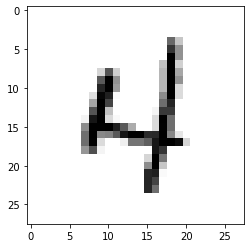

In [11]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

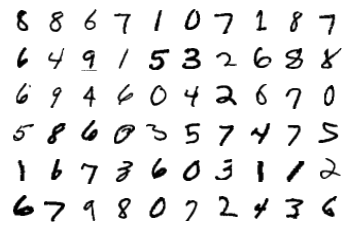

In [12]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
This is imported from model.py file

# Model Params  for 3 versions of the same model
1- With BN + L1 Regularization

2- With Layer Normalization

3- With Group Normalization


In [13]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
BN_model = model.Net('B').to(device) # Takes the parameter to identify with normalization to hit B for Batch Norm + L1 Regularization
LN_model = model.Net('L').to(device) # Takes the parameter to identify with normalization to hit L for Layer Norm
GN_model = model.Net('G').to(device) # Takes the parameter to identify with normalization to hit G for Group Norm
print('----------------------------------------------------------------\n\n')
print ('The model parameters for Batch Mormalization\n')
summary(BN_model, input_size=(1, 28, 28))

print('----------------------------------------------------------------\n\n')
print ('The model parameters for Layer Mormalization\n')
summary(LN_model, input_size=(1, 28, 28))

print('----------------------------------------------------------------\n\n')
print ('The model parameters for Group Mormalization\n')
summary(GN_model, input_size=(1, 28, 28))

cuda
BN in progress
LN in progress
GN in progress
----------------------------------------------------------------


The model parameters for Batch Mormalization

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             576
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
            Conv2d-7            [-1, 8, 22, 22]             576
       BatchNorm2d-8            [-1, 8, 22, 22]              16
           Dropout-9            [-1, 8, 22, 22]               0
             ReLU-10            [-1, 8, 22, 22]               0
        MaxPool2d-11            [-1, 8, 11, 11]               0
    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [14]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
lst = []
lambda_l1 = 0.000001
def train(model, device, train_loader, optimizer, epoch, norm_type):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  lst = []
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)
    modified_pred = y_pred.argmax(dim=1) # needed for mse loss funtions
    modified_pred = modified_pred.type(torch.cuda.FloatTensor)
    

    # Calculate loss
    # L1
    if (norm_type ==  'B'): # This section is for Batch Norm and  L1 Regularization
      loss = F.mse_loss(modified_pred, target)
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1 * l1
      train_losses.append(loss)
    else:
      loss = F.nll_loss(y_pred, target)
      train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  lst = [train_losses,train_acc]
  return(lst)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    lst = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    lst = [test_losses,test_acc]
    return(lst)

# Version -1
## Train and Test of Model with BN + L1

In [15]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
norm_type = 'B'
lambda_l1 = 0.0001
#BN_model =  model.Net('B').to(device)
optimizer = optim.SGD(BN_model.parameters(), lr=0.01, momentum=0.9)
BN_train_lst = []
BN_test_lst = []
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    BN_train_lst = train(BN_model, device, train_loader, optimizer, epoch, norm_type)
    BN_test_lst = test(BN_model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=13.939160346984863 Batch_id=468 Accuracy=10.10: 100%|██████████| 469/469 [00:17<00:00, 27.22it/s]



Test set: Average loss: 2.3334, Accuracy: 985/10000 (9.85%)

EPOCH: 1


Loss=15.810697555541992 Batch_id=468 Accuracy=10.12: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]



Test set: Average loss: 2.3306, Accuracy: 1000/10000 (10.00%)

EPOCH: 2


Loss=15.10947036743164 Batch_id=468 Accuracy=10.27: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]



Test set: Average loss: 2.3275, Accuracy: 991/10000 (9.91%)

EPOCH: 3


Loss=18.314647674560547 Batch_id=468 Accuracy=10.29: 100%|██████████| 469/469 [00:17<00:00, 26.61it/s]



Test set: Average loss: 2.3255, Accuracy: 991/10000 (9.91%)

EPOCH: 4


Loss=15.613733291625977 Batch_id=468 Accuracy=10.36: 100%|██████████| 469/469 [00:17<00:00, 26.73it/s]



Test set: Average loss: 2.3228, Accuracy: 987/10000 (9.87%)

EPOCH: 5


Loss=19.86089515686035 Batch_id=468 Accuracy=10.34: 100%|██████████| 469/469 [00:17<00:00, 26.59it/s]



Test set: Average loss: 2.3195, Accuracy: 984/10000 (9.84%)

EPOCH: 6


Loss=12.69154167175293 Batch_id=468 Accuracy=10.34: 100%|██████████| 469/469 [00:17<00:00, 26.56it/s]



Test set: Average loss: 2.3169, Accuracy: 993/10000 (9.93%)

EPOCH: 7


Loss=12.293169975280762 Batch_id=468 Accuracy=10.38: 100%|██████████| 469/469 [00:17<00:00, 26.51it/s]



Test set: Average loss: 2.3159, Accuracy: 997/10000 (9.97%)

EPOCH: 8


Loss=17.999116897583008 Batch_id=468 Accuracy=10.23: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]



Test set: Average loss: 2.3147, Accuracy: 989/10000 (9.89%)

EPOCH: 9


Loss=13.173964500427246 Batch_id=468 Accuracy=9.97: 100%|██████████| 469/469 [00:17<00:00, 26.31it/s]



Test set: Average loss: 2.3133, Accuracy: 956/10000 (9.56%)

EPOCH: 10


Loss=14.494794845581055 Batch_id=468 Accuracy=9.63: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 2.3137, Accuracy: 925/10000 (9.25%)

EPOCH: 11


Loss=12.732439994812012 Batch_id=468 Accuracy=9.26: 100%|██████████| 469/469 [00:17<00:00, 26.18it/s]



Test set: Average loss: 2.3143, Accuracy: 865/10000 (8.65%)

EPOCH: 12


Loss=18.06399917602539 Batch_id=468 Accuracy=8.78: 100%|██████████| 469/469 [00:17<00:00, 26.15it/s]



Test set: Average loss: 2.3147, Accuracy: 798/10000 (7.98%)

EPOCH: 13


Loss=16.958213806152344 Batch_id=468 Accuracy=8.20: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]



Test set: Average loss: 2.3142, Accuracy: 741/10000 (7.41%)

EPOCH: 14


Loss=15.842170715332031 Batch_id=468 Accuracy=7.71: 100%|██████████| 469/469 [00:18<00:00, 26.02it/s]



Test set: Average loss: 2.3113, Accuracy: 726/10000 (7.26%)

EPOCH: 15


Loss=18.267946243286133 Batch_id=468 Accuracy=7.62: 100%|██████████| 469/469 [00:18<00:00, 25.95it/s]



Test set: Average loss: 2.3062, Accuracy: 770/10000 (7.70%)

EPOCH: 16


Loss=18.006383895874023 Batch_id=468 Accuracy=8.30: 100%|██████████| 469/469 [00:18<00:00, 26.05it/s]



Test set: Average loss: 2.2997, Accuracy: 872/10000 (8.72%)

EPOCH: 17


Loss=14.265823364257812 Batch_id=468 Accuracy=9.29: 100%|██████████| 469/469 [00:17<00:00, 26.18it/s]



Test set: Average loss: 2.3053, Accuracy: 1010/10000 (10.10%)

EPOCH: 18


Loss=18.233722686767578 Batch_id=468 Accuracy=9.98: 100%|██████████| 469/469 [00:17<00:00, 26.15it/s]



Test set: Average loss: 2.2972, Accuracy: 1010/10000 (10.10%)

EPOCH: 19


Loss=16.10796546936035 Batch_id=468 Accuracy=10.02: 100%|██████████| 469/469 [00:17<00:00, 26.32it/s]



Test set: Average loss: 2.3019, Accuracy: 967/10000 (9.67%)



# Version -2
## Train and Test of Model with Layer Norm

In [16]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
norm_type = 'L'
#LN_model =  model.Net('L').to(device)
optimizer = optim.SGD(LN_model.parameters(), lr=0.01, momentum=0.9)
LN_train_lst = []
LN_test_lst = []
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    LN_train_lst = train(LN_model, device, train_loader, optimizer, epoch, norm_type)
    LN_test_lst = test(LN_model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.5077474117279053 Batch_id=468 Accuracy=65.85: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s]



Test set: Average loss: 0.4739, Accuracy: 9096/10000 (90.96%)

EPOCH: 1


Loss=0.15883012115955353 Batch_id=468 Accuracy=94.12: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]



Test set: Average loss: 0.1514, Accuracy: 9653/10000 (96.53%)

EPOCH: 2


Loss=0.06340280920267105 Batch_id=468 Accuracy=96.77: 100%|██████████| 469/469 [00:17<00:00, 27.40it/s]



Test set: Average loss: 0.0975, Accuracy: 9756/10000 (97.56%)

EPOCH: 3


Loss=0.06674603372812271 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:17<00:00, 27.46it/s]



Test set: Average loss: 0.0978, Accuracy: 9729/10000 (97.29%)

EPOCH: 4


Loss=0.12203755229711533 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:17<00:00, 27.46it/s]



Test set: Average loss: 0.0702, Accuracy: 9807/10000 (98.07%)

EPOCH: 5


Loss=0.03610064461827278 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]



Test set: Average loss: 0.0558, Accuracy: 9848/10000 (98.48%)

EPOCH: 6


Loss=0.020112259313464165 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:17<00:00, 27.51it/s]



Test set: Average loss: 0.0594, Accuracy: 9817/10000 (98.17%)

EPOCH: 7


Loss=0.03157195821404457 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]



Test set: Average loss: 0.0472, Accuracy: 9876/10000 (98.76%)

EPOCH: 8


Loss=0.03945837914943695 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:16<00:00, 27.70it/s]



Test set: Average loss: 0.0427, Accuracy: 9882/10000 (98.82%)

EPOCH: 9


Loss=0.07584335654973984 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:17<00:00, 27.56it/s]



Test set: Average loss: 0.0374, Accuracy: 9897/10000 (98.97%)

EPOCH: 10


Loss=0.025491302832961082 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:17<00:00, 27.57it/s]



Test set: Average loss: 0.0399, Accuracy: 9880/10000 (98.80%)

EPOCH: 11


Loss=0.06519904732704163 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:17<00:00, 27.48it/s]



Test set: Average loss: 0.0372, Accuracy: 9888/10000 (98.88%)

EPOCH: 12


Loss=0.0347592867910862 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:17<00:00, 27.17it/s]



Test set: Average loss: 0.0409, Accuracy: 9883/10000 (98.83%)

EPOCH: 13


Loss=0.023548880591988564 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 27.46it/s]



Test set: Average loss: 0.0310, Accuracy: 9917/10000 (99.17%)

EPOCH: 14


Loss=0.020846061408519745 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]



Test set: Average loss: 0.0299, Accuracy: 9917/10000 (99.17%)

EPOCH: 15


Loss=0.017674125730991364 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 27.40it/s]



Test set: Average loss: 0.0292, Accuracy: 9909/10000 (99.09%)

EPOCH: 16


Loss=0.01661757193505764 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]



Test set: Average loss: 0.0379, Accuracy: 9885/10000 (98.85%)

EPOCH: 17


Loss=0.025123082101345062 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s]



Test set: Average loss: 0.0318, Accuracy: 9891/10000 (98.91%)

EPOCH: 18


Loss=0.031796496361494064 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 27.85it/s]



Test set: Average loss: 0.0318, Accuracy: 9905/10000 (99.05%)

EPOCH: 19


Loss=0.024159835651516914 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s]



Test set: Average loss: 0.0278, Accuracy: 9909/10000 (99.09%)



# Version -3
## Train and Test of Model with Group Norm

In [17]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
norm_type = 'G'
#GN_model =  model.Net('G').to(device)
optimizer = optim.SGD(GN_model.parameters(), lr=0.01, momentum=0.9)
GN_train_lst = []
GN_test_lst = []
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    GN_train_lst = train(GN_model, device, train_loader, optimizer, epoch, norm_type)
    GN_test_lst = test(GN_model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.2119145393371582 Batch_id=468 Accuracy=74.72: 100%|██████████| 469/469 [00:17<00:00, 26.43it/s]



Test set: Average loss: 0.1671, Accuracy: 9585/10000 (95.85%)

EPOCH: 1


Loss=0.11011669039726257 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:18<00:00, 25.47it/s]



Test set: Average loss: 0.0838, Accuracy: 9778/10000 (97.78%)

EPOCH: 2


Loss=0.03673155978322029 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:17<00:00, 26.52it/s]



Test set: Average loss: 0.0590, Accuracy: 9836/10000 (98.36%)

EPOCH: 3


Loss=0.02160886488854885 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:17<00:00, 26.12it/s]



Test set: Average loss: 0.0458, Accuracy: 9875/10000 (98.75%)

EPOCH: 4


Loss=0.04673932120203972 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 0.0412, Accuracy: 9875/10000 (98.75%)

EPOCH: 5


Loss=0.03910798579454422 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 0.0448, Accuracy: 9866/10000 (98.66%)

EPOCH: 6


Loss=0.024753836914896965 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s]



Test set: Average loss: 0.0322, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Loss=0.06062206253409386 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:17<00:00, 26.30it/s]



Test set: Average loss: 0.0352, Accuracy: 9887/10000 (98.87%)

EPOCH: 8


Loss=0.055624376982450485 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:17<00:00, 26.07it/s]



Test set: Average loss: 0.0350, Accuracy: 9889/10000 (98.89%)

EPOCH: 9


Loss=0.0042935870587825775 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:18<00:00, 25.67it/s]



Test set: Average loss: 0.0316, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.013767078518867493 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]



Test set: Average loss: 0.0439, Accuracy: 9866/10000 (98.66%)

EPOCH: 11


Loss=0.011614900082349777 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:18<00:00, 25.16it/s]



Test set: Average loss: 0.0334, Accuracy: 9895/10000 (98.95%)

EPOCH: 12


Loss=0.017812753096222878 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:18<00:00, 25.15it/s]



Test set: Average loss: 0.0335, Accuracy: 9907/10000 (99.07%)

EPOCH: 13


Loss=0.021046889945864677 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s]



Test set: Average loss: 0.0290, Accuracy: 9907/10000 (99.07%)

EPOCH: 14


Loss=0.0393209271132946 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:18<00:00, 25.50it/s]



Test set: Average loss: 0.0306, Accuracy: 9912/10000 (99.12%)

EPOCH: 15


Loss=0.019111519679427147 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]



Test set: Average loss: 0.0265, Accuracy: 9920/10000 (99.20%)

EPOCH: 16


Loss=0.08468969911336899 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:18<00:00, 25.55it/s]



Test set: Average loss: 0.0283, Accuracy: 9914/10000 (99.14%)

EPOCH: 17


Loss=0.00874320138245821 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:18<00:00, 25.26it/s]



Test set: Average loss: 0.0236, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.007012073416262865 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:18<00:00, 25.35it/s]



Test set: Average loss: 0.0262, Accuracy: 9916/10000 (99.16%)

EPOCH: 19


Loss=0.0046033007092773914 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:18<00:00, 25.22it/s]



Test set: Average loss: 0.0250, Accuracy: 9926/10000 (99.26%)



# Printing Test Loss of all 3 models

Test Loss results for all 3 models


Text(0.5, 1.0, 'Test Loss for all 3 models')

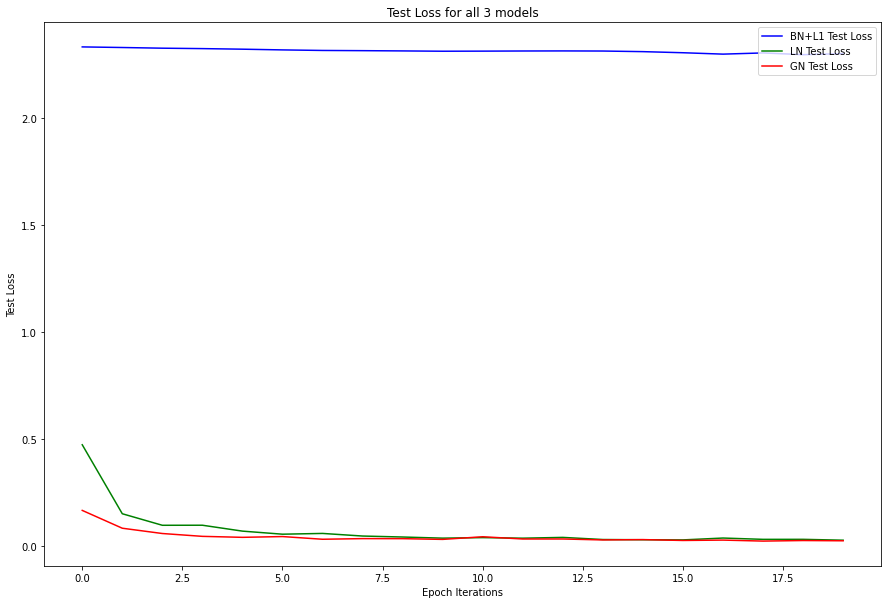

In [18]:
print('Test Loss results for all 3 models')
fig, axs = plt.subplots(1,1,figsize=(15,10))
axs.plot(BN_test_lst[0],c='b',label = 'BN+L1 Test Loss')
axs.plot(LN_test_lst[0],c='g',label = 'LN Test Loss')
axs.plot(GN_test_lst[0],c='r',label = 'GN Test Loss')
axs.legend(loc=1)
plt.xlabel('Epoch Iterations')
plt.ylabel('Test Loss')
axs.set_title("Test Loss for all 3 models")

# Printing Test Accuracy of all 3 models

Test Accuracy results for all 3 models


Text(0.5, 1.0, 'Test Accuracy for all 3 models')

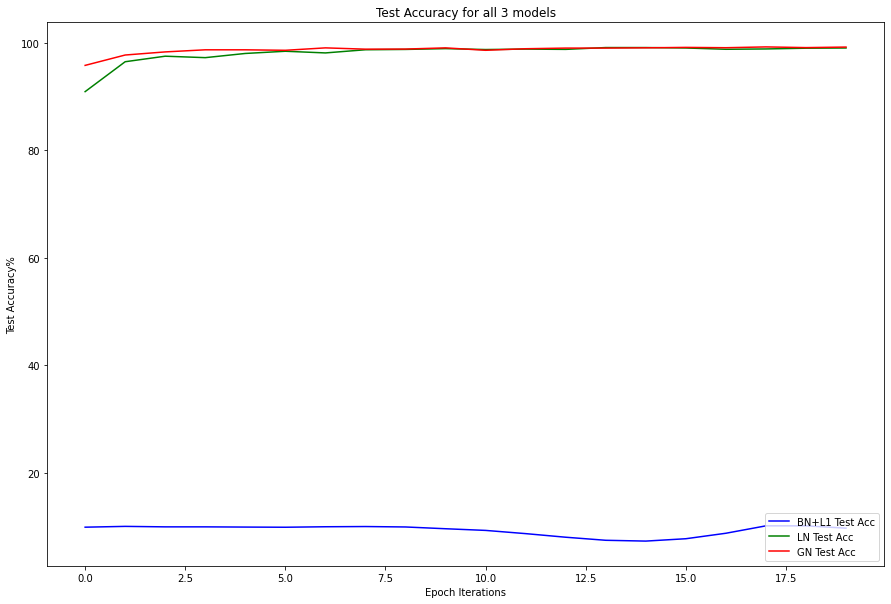

In [19]:
print('Test Accuracy results for all 3 models')
fig, axs = plt.subplots(1,1,figsize=(15,10))
axs.plot(BN_test_lst[1],c='b',label = 'BN+L1 Test Acc')
axs.plot(LN_test_lst[1],c='g',label = 'LN Test Acc')
axs.plot(GN_test_lst[1],c='r',label = 'GN Test Acc')
axs.legend(loc=4)
plt.xlabel('Epoch Iterations')
plt.ylabel('Test Accuracy%')
axs.set_title("Test Accuracy for all 3 models")

Results for Batch Normalization


Text(0.5, 1.0, 'BN Test Accuracy')

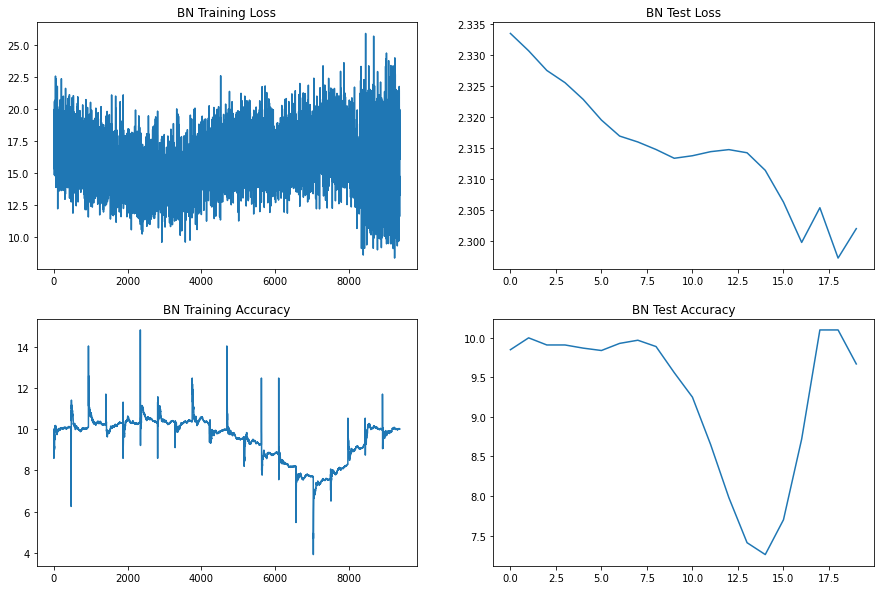

In [20]:
print('Results for Batch Normalization')
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(BN_train_lst[0])
axs[0, 0].set_title("BN Training Loss")
axs[1, 0].plot(BN_train_lst[1])
axs[1, 0].set_title("BN Training Accuracy")
axs[0, 1].plot(BN_test_lst[0])
axs[0, 1].set_title("BN Test Loss")
axs[1, 1].plot(BN_test_lst[1])
axs[1, 1].set_title("BN Test Accuracy")

Results for Layer Normalization


Text(0.5, 1.0, 'LN Test Accuracy')

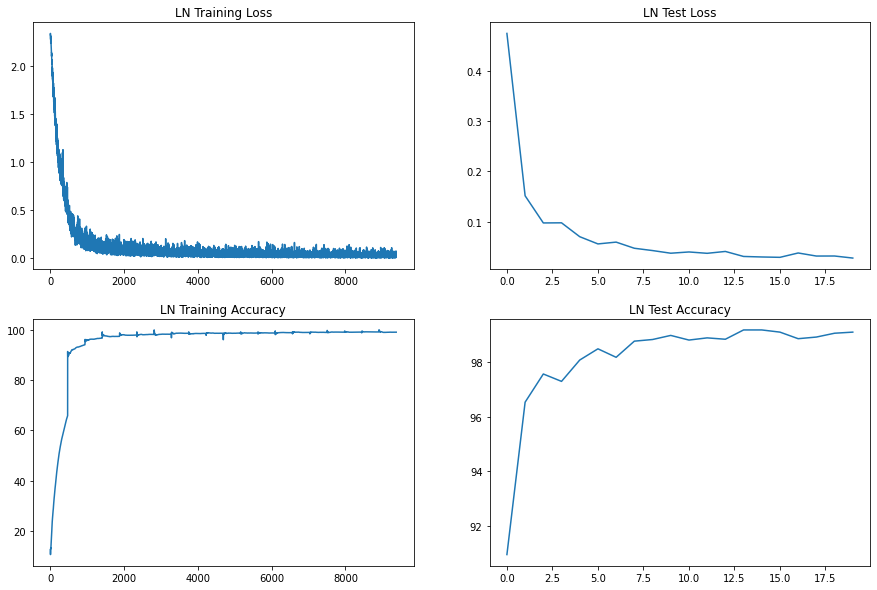

In [21]:
print('Results for Layer Normalization')
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(LN_train_lst[0])
axs[0, 0].set_title("LN Training Loss")
axs[1, 0].plot(LN_train_lst[1])
axs[1, 0].set_title("LN Training Accuracy")
axs[0, 1].plot(LN_test_lst[0])
axs[0, 1].set_title("LN Test Loss")
axs[1, 1].plot(LN_test_lst[1])
axs[1, 1].set_title("LN Test Accuracy")

Results for Group Normalization


Text(0.5, 1.0, 'GN Test Accuracy')

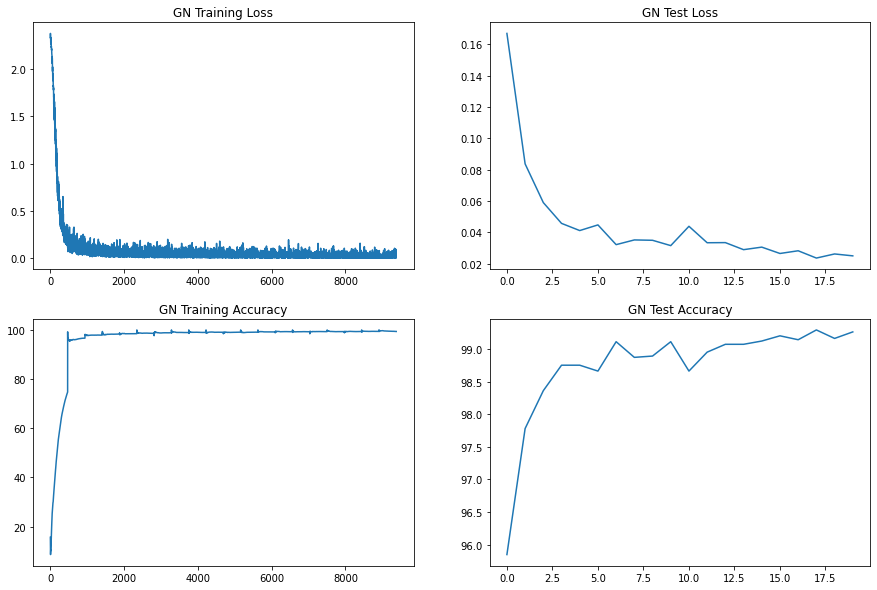

In [22]:
print('Results for Group Normalization')
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(GN_train_lst[0])
axs[0, 0].set_title("GN Training Loss")
axs[1, 0].plot(GN_train_lst[1])
axs[1, 0].set_title("GN Training Accuracy")
axs[0, 1].plot(GN_test_lst[0])
axs[0, 1].set_title("GN Test Loss")
axs[1, 1].plot(GN_test_lst[1])
axs[1, 1].set_title("GN Test Accuracy")

# Analysis:

1. Batch Norm with L1 Regularization yields poor accuracy.
2. Layer Normalization and Group Normalization yields a very high accuracy.



# Priniting 10 misclassified images by BN + L1 model

Misclassified images for Batch Normalization


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Checking batch # 1


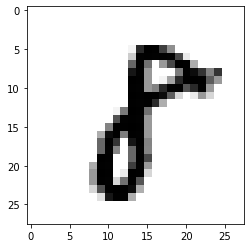

The model predicted the above image as - 3
Actual label of the above image is - 8


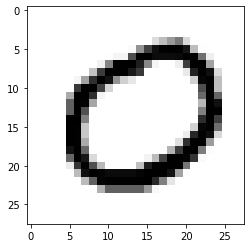

The model predicted the above image as - 3
Actual label of the above image is - 0


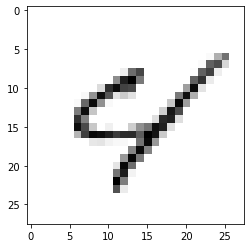

The model predicted the above image as - 3
Actual label of the above image is - 4


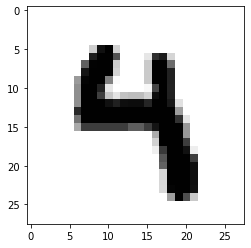

The model predicted the above image as - 3
Actual label of the above image is - 4


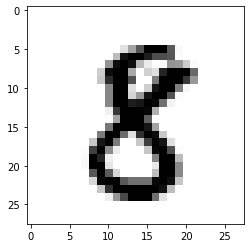

The model predicted the above image as - 3
Actual label of the above image is - 8


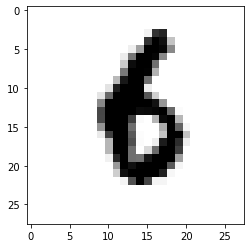

The model predicted the above image as - 3
Actual label of the above image is - 6


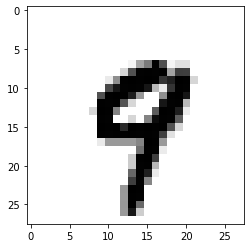

The model predicted the above image as - 3
Actual label of the above image is - 9


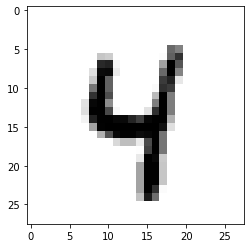

The model predicted the above image as - 3
Actual label of the above image is - 4


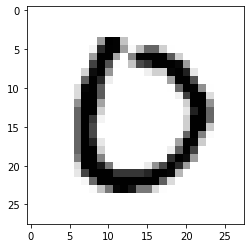

The model predicted the above image as - 3
Actual label of the above image is - 0


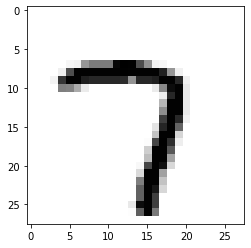

The model predicted the above image as - 9
Actual label of the above image is - 7
10 misclassified images found.. Processing stopped
10 misclassified images as below -  


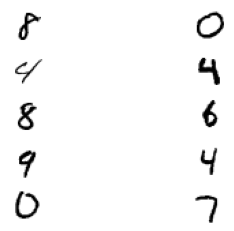

In [24]:
print('Misclassified images for Batch Normalization')
img_counter = 0;
i = 0;
img_lst = []
for test_batch in test_loader:
  i += 1
  print(f'Checking batch # {i}')
  #test_batch = next(iter(test_loader)) # Get the first batch from the train loader
  batch_img, batch_lbl = test_batch
  for j in range(len(batch_img)): # processing sets of images in each batch
    img, lbl = batch_img.data[j].to(device), batch_lbl.data[j].to(device)
    #img, lbl = batch_img.data[j], batch_lbl.data[j]
    #img, lbl = img.to(device), lbl.to(device)
    img1 = img.to('cpu')
    test_pred = BN_model(img.reshape(1,1,28,28)) # passing each test image to the model
    predicted_label = test_pred.reshape(-1,10).argmax(dim=1).item() # finding the max tensor position to determine the predicted label 
    if (predicted_label != lbl): # Check to see if the model prediction was correct and print 10 misclassified images
      img_counter += 1
      plt.imshow(img1.numpy().squeeze(), cmap='gray_r')
      plt.show()
      print(f'The model predicted the above image as - {predicted_label}')
      print(f'Actual label of the above image is - {lbl}')
      
      temp_img = img1.numpy().squeeze()
      img_lst.append(temp_img)
      #plt.subplot(5, 2, 10)
      #plt.axis('off')
      #plt.imshow(img1.numpy().squeeze(), cmap='gray_r')
      
      if (img_counter > 9):
        break
  if (img_counter > 9):
    print(f'10 misclassified images found.. Processing stopped')
    break
print ('10 misclassified images as below -  ')
for i in range(len(img_lst)):
  plt.subplot(5, 2, i+1)
  plt.axis('off')
  plt.imshow(img_lst[i].squeeze(), cmap='gray_r')

# Priniting 10 misclassified images by Layer Norm model

Misclassified images for Layer Normalization


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Checking batch # 1
Checking batch # 2


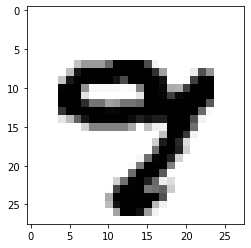

The model predicted the above image as - 7
Actual label of the above image is - 9


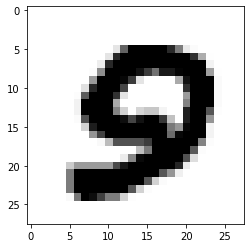

The model predicted the above image as - 5
Actual label of the above image is - 9
Checking batch # 3


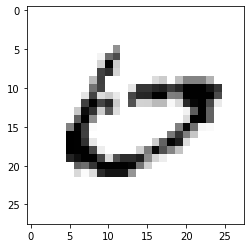

The model predicted the above image as - 0
Actual label of the above image is - 6


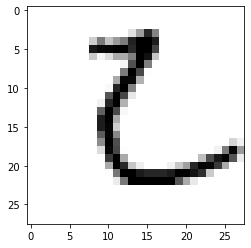

The model predicted the above image as - 6
Actual label of the above image is - 2


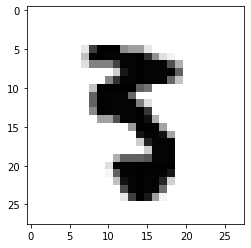

The model predicted the above image as - 5
Actual label of the above image is - 3
Checking batch # 4


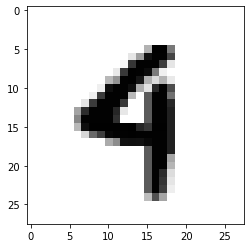

The model predicted the above image as - 9
Actual label of the above image is - 4
Checking batch # 5
Checking batch # 6
Checking batch # 7


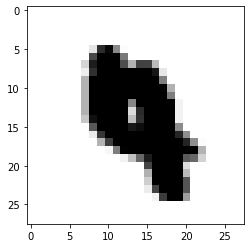

The model predicted the above image as - 9
Actual label of the above image is - 4
Checking batch # 8
Checking batch # 9
Checking batch # 10


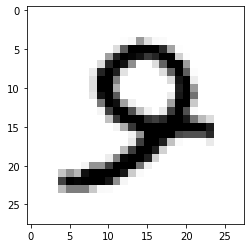

The model predicted the above image as - 8
Actual label of the above image is - 9


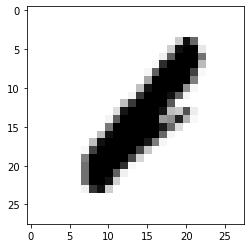

The model predicted the above image as - 4
Actual label of the above image is - 1


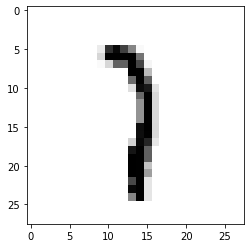

The model predicted the above image as - 1
Actual label of the above image is - 7
10 misclassified images found.. Processing stopped
10 misclassified images as below -  


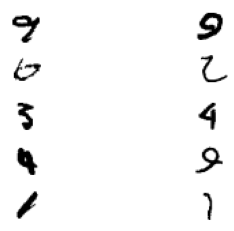

In [25]:
print('Misclassified images for Layer Normalization')
img_counter = 0;
i = 0;
img_lst = []
for test_batch in test_loader:
  i += 1
  print(f'Checking batch # {i}')
  #test_batch = next(iter(test_loader)) # Get the first batch from the train loader
  batch_img, batch_lbl = test_batch
  for j in range(len(batch_img)): # processing sets of images in each batch
    img, lbl = batch_img.data[j].to(device), batch_lbl.data[j].to(device)
    #img, lbl = batch_img.data[j], batch_lbl.data[j]
    #img, lbl = img.to(device), lbl.to(device)
    img1 = img.to('cpu')
    test_pred = LN_model(img.reshape(1,1,28,28)) # passing each test image to the model
    predicted_label = test_pred.reshape(-1,10).argmax(dim=1).item() # finding the max tensor position to determine the predicted label 
    if (predicted_label != lbl): # Check to see if the model prediction was correct and print 10 misclassified images
      img_counter += 1
      plt.imshow(img1.numpy().squeeze(), cmap='gray_r')
      plt.show()
      print(f'The model predicted the above image as - {predicted_label}')
      print(f'Actual label of the above image is - {lbl}')
      
      temp_img = img1.numpy().squeeze()
      img_lst.append(temp_img)
      #plt.subplot(5, 2, 10)
      #plt.axis('off')
      #plt.imshow(img1.numpy().squeeze(), cmap='gray_r')
      
      if (img_counter > 9):
        break
  if (img_counter > 9):
    print(f'10 misclassified images found.. Processing stopped')
    break
print ('10 misclassified images as below -  ')
for i in range(len(img_lst)):
  plt.subplot(5, 2, i+1)
  plt.axis('off')
  plt.imshow(img_lst[i].squeeze(), cmap='gray_r')

# Priniting 10 misclassified images by Group Norm model

Misclassified images for Group Normalization


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Checking batch # 1
Checking batch # 2
Checking batch # 3
Checking batch # 4


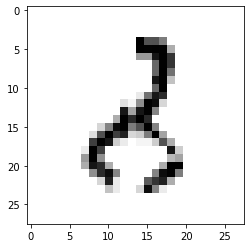

The model predicted the above image as - 2
Actual label of the above image is - 8
Checking batch # 5


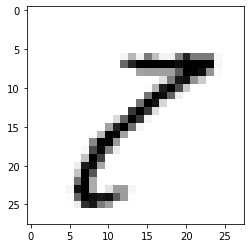

The model predicted the above image as - 2
Actual label of the above image is - 7
Checking batch # 6


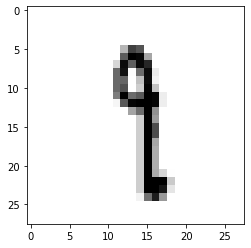

The model predicted the above image as - 4
Actual label of the above image is - 9


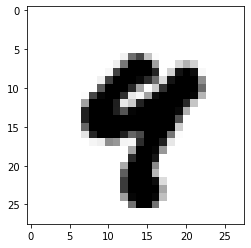

The model predicted the above image as - 9
Actual label of the above image is - 4
Checking batch # 7


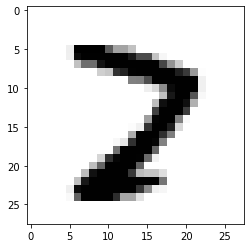

The model predicted the above image as - 2
Actual label of the above image is - 7
Checking batch # 8


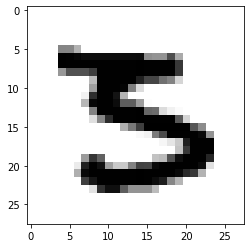

The model predicted the above image as - 5
Actual label of the above image is - 3
Checking batch # 9
Checking batch # 10
Checking batch # 11


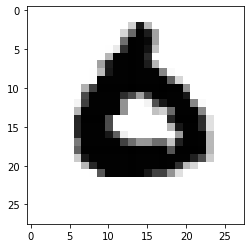

The model predicted the above image as - 0
Actual label of the above image is - 6


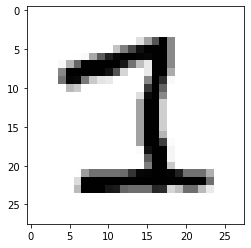

The model predicted the above image as - 3
Actual label of the above image is - 1
Checking batch # 12


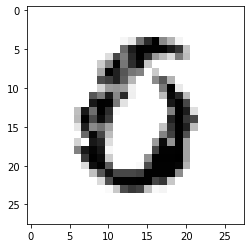

The model predicted the above image as - 5
Actual label of the above image is - 0
Checking batch # 13


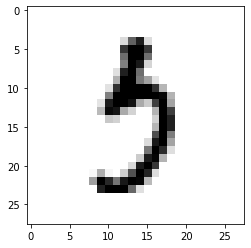

The model predicted the above image as - 5
Actual label of the above image is - 3
10 misclassified images found.. Processing stopped
10 misclassified images as below -  


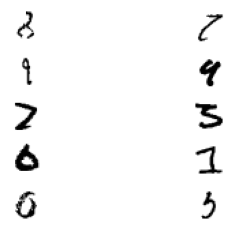

In [26]:
print('Misclassified images for Group Normalization')
img_counter = 0;
i = 0;
img_lst = []
for test_batch in test_loader:
  i += 1
  print(f'Checking batch # {i}')
  #test_batch = next(iter(test_loader)) # Get the first batch from the train loader
  batch_img, batch_lbl = test_batch
  for j in range(len(batch_img)): # processing sets of images in each batch
    img, lbl = batch_img.data[j].to(device), batch_lbl.data[j].to(device)
    #img, lbl = batch_img.data[j], batch_lbl.data[j]
    #img, lbl = img.to(device), lbl.to(device)
    img1 = img.to('cpu')
    test_pred = GN_model(img.reshape(1,1,28,28)) # passing each test image to the model
    predicted_label = test_pred.reshape(-1,10).argmax(dim=1).item() # finding the max tensor position to determine the predicted label 
    if (predicted_label != lbl): # Check to see if the model prediction was correct and print 10 misclassified images
      img_counter += 1
      plt.imshow(img1.numpy().squeeze(), cmap='gray_r')
      plt.show()
      print(f'The model predicted the above image as - {predicted_label}')
      print(f'Actual label of the above image is - {lbl}')
      
      temp_img = img1.numpy().squeeze()
      img_lst.append(temp_img)
      #plt.subplot(5, 2, 10)
      #plt.axis('off')
      #plt.imshow(img1.numpy().squeeze(), cmap='gray_r')
      
      if (img_counter > 9):
        break
  if (img_counter > 9):
    print(f'10 misclassified images found.. Processing stopped')
    break
print ('10 misclassified images as below -  ')
for i in range(len(img_lst)):
  plt.subplot(5, 2, i+1)
  plt.axis('off')
  plt.imshow(img_lst[i].squeeze(), cmap='gray_r')

In [27]:
import datetime as dt
from datetime import date, timedelta, time
print(f'Process ends at {str(dt.datetime.now())}')

Process ends at 2021-11-01 13:07:29.277017
